In [1]:
import torch
from diffusers import StableDiffusionGLIGENPipeline
from diffusers.utils import load_image
from compel import Compel
import numpy as np
import cv2
import matplotlib.pyplot as plt


#  Generation Model Initialization
pipe = StableDiffusionGLIGENPipeline.from_pretrained(
    "masterful/gligen-1-4-inpainting-text-box", 
    variant="fp16", 
    torch_dtype=torch.float16
)
pipe = pipe.to("cuda:0")
compel = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)
generator = torch.Generator(device='cuda:0').manual_seed(777)

# 시각화 함수
def visualization(input_image, generated_image, boxes):
    np_input = np.array(input_image)
    np_genai = np.array(generated_image)
    np_genai_copy = np_genai.copy()
    height, width, _ = np_genai.shape

    for box in boxes:
        min_x, min_y, max_x, max_y = box
        min_x = int(min_x * width)
        min_y = int(min_y * height)
        max_x = int(max_x * width)
        max_y = int(max_y * height)
        cv2.rectangle(np_genai_copy, (min_x, min_y), (max_x, max_y), (0, 0, 255), 2)

    plt.imshow(np_genai_copy)
    plt.axis('off')
    plt.show()

/home/work/.conda/envs/main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/home/work/.conda/envs/main/lib/python3.12/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--masterful--gligen-1-4-inpainting-text-box/snapshots/d6d957f8d27c40889c0d570a616571a5645c8be3/vae: Error no file named diffusion_pytorch_model.fp16.safetensors found in directory /home/work/.cache/huggingface/hub/models--masterful--gligen-1-4-inpainting-text-box/snapshots/d6d957f8d27c40889c0d570a616571a5645c

**본 프로젝트에서는 아래와 같이 3개의 프롬프트를 사용. 이때, 사용자 편의성을 고려하기 위해, 단일 Style 키워드만 입력 받음**

1. 사실적인 가구를 생성하기 위한 키워드 (Server Default)
    - Best quality, Cinematic lighting, Hyper-detailed textures …
2. 방의 스타일을 고려한 가구를 생성하기 위한 배경 맞춤 키워드 (Server Default)
    - Harmony with ambient lightning, Accurate perspective, Scale with the scene, …
3. 가구 스타일 관련 키워드 (User Input)
    - **User로부터 Scandinavian 입력 받음 → 서버에서 Scandinavian과 유사한 키워드로 전환**
    - Scandinavian furniture design, Natural wood, Bright and airy, …

/home/work/.conda/envs/main/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_gligen/pipeline_stable_diffusion_gligen.py:747: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  if gligen_inpaint_image.size != (self.vae.sample_size, self.vae.sample_size):
/home/work/.conda/envs/main/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_gligen/pipeline_stable_diffusion_gligen.py:748: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  gligen_inpaint_image = self.target_size_center_crop(gligen_inpaint_image, self.vae.sample_size)
100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


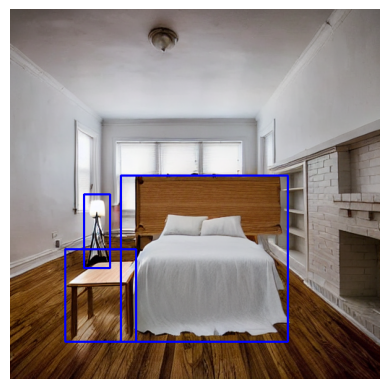

In [2]:
input_image        = load_image("./bg-for-prompt-test.jpeg")
boxes              = [[0.15, 0.65, 0.34, 0.9], [0.20, 0.50, 0.27, 0.70], [0.3, 0.45, 0.75, 0.9]]
phrases            = ["a dresser", "a lamp", "blue bed"]
prompt_default     = "Best quality, Ultra high quality, Highly detailed, Intricate details, Photo-realistic, Cinematic lighting, Hyper-detailed textures, Well-balanced layout, Spatial harmony, 8k resolution"
prompt_default_fit = "Harmony with ambient lightning, Blending seamlessly with surroundings, Accurate perspective, Scale with the scene"

# prompt_style       = "Contemporary furniture design, Clean lines, Sleek surfaces, Neutral tones, Bold color accents, Minimalistic elegance, Subtle textures, Modern comfort"
# prompt_style       = "Industrial furniture design, Exposed metal, Industrial metal frame, Visible framework, Urban aesthetics, Neutral tones, Functional and raw charm"
# prompt_style       = "Mid-century modern furniture design, Natural wood, Warm wood tones, Smooth contours, Retro aesthetics, Organic shapes, Functional design, Minimalistic flair"
# prompt_style       = "Modern minimalist furniture design, Sleek lines, Clear structure, Achromatic tones, Contemporary aesthetics, Functional elegance, Subtle reflection"
# prompt_style       = "Rustic farmhouse furniture design, Natural wood grain, Unpolished texture, Vintage charm, Cozy aesthetics, Earthy tones"
prompt_style       = "Scandinavian furniture design, Natural wood, Warm wood tones, Bright and airy, Clear lines, Minimalist aesthetics, Functional simplicity"

prompt             = f'("{prompt_default}", "{prompt_default_fit}", "({prompt_style})+++").and()'

positive = compel.build_conditioning_tensor(prompt)
negative = compel.build_conditioning_tensor("")
[positive, negative] = compel.pad_conditioning_tensors_to_same_length([positive, negative])

images = pipe(
    prompt_embeds          = positive,
    negative_prompt_embeds = negative,
    gligen_phrases         = phrases,
    gligen_inpaint_image   = input_image,
    gligen_boxes           = boxes,
    gligen_scheduled_sampling_beta = 1.0,
    guidance_scale                 = 8.0,
    output_type="pil",
    num_inference_steps=50,
    generator=generator
).images

visualization(input_image, images[0], boxes)